# Step 0. Setup and Paths.

-> Raw Data exploration, pre-transformation.
- Exploring the raw FastF1 exports - Laps, Drivers, Weather, Results.
- Working with the folder structure -> data/raw/{session_key}

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import glob
import json

PROJECT_DIR = Path.cwd().parents[0]
RAW_DATA_DIR = PROJECT_DIR / "data" / "raw"
PROCESSED_DATA_DIR = PROJECT_DIR / "data" / "processed"
CACHE_DIR = Path.cwd().resolve().parents[1] / "f1_cache"

print('Project Directory: ',PROJECT_DIR)
print('Raw Data Directory: ',RAW_DATA_DIR)
print('Processed Data Directory: ',PROCESSED_DATA_DIR)
print('Cache Directory: ',CACHE_DIR)

Project Directory:  /Users/pratyushagarwal/Desktop/PROJECTS/F1_Projects/race_weekend_data_pipeline
Raw Data Directory:  /Users/pratyushagarwal/Desktop/PROJECTS/F1_Projects/race_weekend_data_pipeline/data/raw
Processed Data Directory:  /Users/pratyushagarwal/Desktop/PROJECTS/F1_Projects/race_weekend_data_pipeline/data/processed
Cache Directory:  /Users/pratyushagarwal/Desktop/PROJECTS/F1_Projects/f1_cache


# Step 1. Listing all available sessions to pick one.

In [2]:
session_dirs = sorted(
    [Path(p).name for p in glob.glob(str(RAW_DATA_DIR / "*")) if Path(p).is_dir()]
)
len(session_dirs), session_dirs[:20]

(60,
 ['2024_01_Q',
  '2024_01_R',
  '2024_02_Q',
  '2024_02_R',
  '2024_03_Q',
  '2024_03_R',
  '2024_04_Q',
  '2024_04_R',
  '2024_05_Q',
  '2024_05_R',
  '2024_05_S',
  '2024_05_SQ',
  '2024_06_Q',
  '2024_06_R',
  '2024_06_S',
  '2024_06_SQ',
  '2024_07_Q',
  '2024_07_R',
  '2024_08_Q',
  '2024_08_R'])

In [3]:
session_key = session_dirs[1] if session_dirs else None
session_key

'2024_01_R'

# Step 2. Loading raw files - laps, weather, results, drivers.

In [4]:
in_dir = RAW_DATA_DIR / session_key
display(in_dir, list(p.name for p in in_dir.glob("*")))

# Loading data that exists, with guards in place.
laps = pd.read_parquet(in_dir / 'laps.parquet') if (in_dir / 'laps.parquet').exists() else pd.DataFrame()
weather = pd.read_parquet(in_dir / 'weather.parquet') if (in_dir / 'weather.parquet').exists() else pd.DataFrame()
results = pd.read_parquet(in_dir / 'results.parquet') if (in_dir / 'results.parquet').exists() else pd.DataFrame()
drivers = pd.read_parquet(in_dir / 'drivers.parquet') if (in_dir / 'drivers.parquet').exists() else pd.DataFrame()

laps.shape, weather.shape, results.shape, drivers.shape

PosixPath('/Users/pratyushagarwal/Desktop/PROJECTS/F1_Projects/race_weekend_data_pipeline/data/raw/2024_01_R')

['drivers.parquet',
 'weather.parquet',
 'laps.parquet',
 'results.parquet',
 'session_meta.json']

((1129, 31), (157, 8), (20, 22), (20, 6))

# Step 3. Quick Schema and Dtypes overview.

In [5]:
def peek(df: pd.DataFrame, name: str, n=5):
    print(f"\n -- {name} --")
    if df.empty:
        print("DataFrame is empty.")
        return
    display(df.head(n))

    print(f'\n {name} -- Datatypes -- ')
    display(df.dtypes.to_frame(name='dtype'))

    print(f'\n {name} -- Missing Values -- ')
    display((df.isna().mean()*100).round(2).rename('null_percentage').to_frame())

peek(laps, 'Laps')
peek(weather, 'Weather')
peek(results, 'Results')
peek(drivers, 'Drivers')


 -- Laps --


,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,FreshTyre,Team,LapStartTime,LapStartDate,TrackStatus,Position,Deleted,DeletedReason,FastF1Generated,IsAccurate
0,0 days 01:01:37.489000,VER,1,0 days 00:01:37.284000,1.0,1.0,NaT,NaT,NaT,0 days 00:00:41.266000,...,False,Red Bull Racing,0 days 00:59:59.911000,NaT,12,1.0,None,,False,False
1,0 days 01:03:13.785000,VER,1,0 days 00:01:36.296000,2.0,1.0,NaT,NaT,0 days 00:00:30.916000,0 days 00:00:41.661000,...,False,Red Bull Racing,0 days 01:01:37.489000,NaT,1,1.0,None,,False,True
2,0 days 01:04:50.538000,VER,1,0 days 00:01:36.753000,3.0,1.0,NaT,NaT,0 days 00:00:30.999000,0 days 00:00:41.966000,...,False,Red Bull Racing,0 days 01:03:13.785000,NaT,1,1.0,None,,False,True
3,0 days 01:06:27.185000,VER,1,0 days 00:01:36.647000,4.0,1.0,NaT,NaT,0 days 00:00:30.931000,0 days 00:00:41.892000,...,False,Red Bull Racing,0 days 01:04:50.538000,NaT,1,1.0,None,,False,True
4,0 days 01:08:04.358000,VER,1,0 days 00:01:37.173000,5.0,1.0,NaT,NaT,0 days 00:00:31.255000,0 days 00:00:42.056000,...,False,Red Bull Racing,0 days 01:06:27.185000,NaT,1,1.0,None,,False,True



 Laps -- Datatypes -- 


,dtype
Time,timedelta64[ns]
Driver,object
DriverNumber,object
LapTime,timedelta64[ns]
LapNumber,float64
Stint,float64
PitOutTime,timedelta64[ns]
PitInTime,timedelta64[ns]
Sector1Time,timedelta64[ns]
Sector2Time,timedelta64[ns]



 Laps -- Missing Values -- 


,null_percentage
Time,0.00
Driver,0.00
DriverNumber,0.00
LapTime,0.18
LapNumber,0.00
Stint,0.00
PitOutTime,96.19
PitInTime,96.19
Sector1Time,1.86
Sector2Time,0.00



 -- Weather --


,Time,AirTemp,Humidity,Pressure,Rainfall,TrackTemp,WindDirection,WindSpeed
0,0 days 00:00:14.093000,18.9,46.0,1017.1,False,26.5,162,0.9
1,0 days 00:01:14.084000,18.9,46.0,1017.0,False,26.5,55,1.0
2,0 days 00:02:14.093000,18.9,46.0,1017.0,False,26.5,55,1.0
3,0 days 00:03:14.090000,18.9,45.0,1017.0,False,26.2,85,1.1
4,0 days 00:04:14.091000,18.9,46.0,1017.0,False,26.2,178,1.0



 Weather -- Datatypes -- 


,dtype
Time,timedelta64[ns]
AirTemp,float64
Humidity,float64
Pressure,float64
Rainfall,bool
TrackTemp,float64
WindDirection,int64
WindSpeed,float64



 Weather -- Missing Values -- 


,null_percentage
Time,0.0
AirTemp,0.0
Humidity,0.0
Pressure,0.0
Rainfall,0.0
TrackTemp,0.0
WindDirection,0.0
WindSpeed,0.0



 -- Results --


,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,Position,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,...,1.0,1,1.0,NaT,NaT,NaT,0 days 01:31:44.742000,Finished,26.0,57.0
11,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,...,2.0,2,5.0,NaT,NaT,NaT,0 days 00:00:22.457000,Finished,18.0,57.0
55,55,C SAINZ,SAI,sainz,Ferrari,e8002d,ferrari,Carlos,Sainz,Carlos Sainz,...,3.0,3,4.0,NaT,NaT,NaT,0 days 00:00:25.110000,Finished,15.0,57.0
16,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,...,4.0,4,2.0,NaT,NaT,NaT,0 days 00:00:39.669000,Finished,12.0,57.0
63,63,G RUSSELL,RUS,russell,Mercedes,27f4d2,mercedes,George,Russell,George Russell,...,5.0,5,3.0,NaT,NaT,NaT,0 days 00:00:46.788000,Finished,10.0,57.0



 Results -- Datatypes -- 


,dtype
DriverNumber,object
BroadcastName,object
Abbreviation,object
DriverId,object
TeamName,object
TeamColor,object
TeamId,object
FirstName,object
LastName,object
FullName,object



 Results -- Missing Values -- 


,null_percentage
DriverNumber,0.0
BroadcastName,0.0
Abbreviation,0.0
DriverId,0.0
TeamName,0.0
TeamColor,0.0
TeamId,0.0
FirstName,0.0
LastName,0.0
FullName,0.0



 -- Drivers --


,driver_number,driver_id,broadcast_name,full_name,team,nationality
0,1,VER,M VERSTAPPEN,Max Verstappen,Red Bull Racing,None
1,11,PER,S PEREZ,Sergio Perez,Red Bull Racing,None
2,55,SAI,C SAINZ,Carlos Sainz,Ferrari,None
3,16,LEC,C LECLERC,Charles Leclerc,Ferrari,None
4,63,RUS,G RUSSELL,George Russell,Mercedes,None



 Drivers -- Datatypes -- 


,dtype
driver_number,object
driver_id,object
broadcast_name,object
full_name,object
team,object
nationality,object



 Drivers -- Missing Values -- 


,null_percentage
driver_number,0.0
driver_id,0.0
broadcast_name,0.0
full_name,0.0
team,0.0
nationality,100.0


# Step 4. Laps Table - Core columns, time deltas, basic stats.

In [6]:
td_cols = [c for c in laps.columns if pd.api.types.is_timedelta64_dtype(laps[c])]
num_cols = [c for c in laps.columns if pd.api.types.is_numeric_dtype(laps[c])]
cat_cols = [c for c in laps.columns if pd.api.types.is_object_dtype(laps[c]) or isinstance(laps[c].dtype, pd.CategoricalDtype)]
# Could also be written as :
# cat_cols = list(laps.select_dtypes(include=["object", "category"]).columns)

td_cols, num_cols[:10], cat_cols[:10]

(['Time',
  'LapTime',
  'PitOutTime',
  'PitInTime',
  'Sector1Time',
  'Sector2Time',
  'Sector3Time',
  'Sector1SessionTime',
  'Sector2SessionTime',
  'Sector3SessionTime',
  'LapStartTime'],
 ['LapNumber',
  'Stint',
  'SpeedI1',
  'SpeedI2',
  'SpeedFL',
  'SpeedST',
  'IsPersonalBest',
  'TyreLife',
  'FreshTyre',
  'Position'],
 ['Driver',
  'DriverNumber',
  'Compound',
  'Team',
  'TrackStatus',
  'Deleted',
  'DeletedReason'])

In [7]:
def to_ms(s: pd.Series) -> pd.Series:
    return s.dt.total_seconds().multiply(1000)

# Previewing a few time delta columns converted to milliseconds without mutating the original dataframe.
preview = pd.DataFrame() 
for c in ['LapTime', 'Sector1Time', 'Sector2Time', 'Sector3Time']:
    if c in laps.columns and pd.api.types.is_timedelta64_dtype(laps[c]):
        preview[c.replace('Time', 'Time_ms')] = to_ms(laps[c])

preview.describe(percentiles=[0.1, 0.5, 0.9]).T if not preview.empty else "No time delta timing columns found."

,count,mean,std,min,10%,50%,90%,max
LapTime_ms,1127.0,98004.108252,4500.312961,92608.0,95262.2,97046.0,99381.6,132438.0
Sector1Time_ms,1108.0,31819.007220,4542.857493,29741.0,30500.7,30954.5,31457.3,83300.0
Sector2Time_ms,1129.0,42132.447298,686.102329,39916.0,41225.4,42107.0,42968.0,46732.0
Sector3Time_ms,1129.0,24030.199291,697.919024,22951.0,23482.8,23907.0,24447.0,31828.0


In [8]:

has_laptime = ('LapTime' in laps.columns) and pd.api.types.is_timedelta64_dtype(laps['LapTime'])
laps2 = laps.assign(LapTime_ms = to_ms(laps['LapTime']) if has_laptime else np.nan)

try:
    grp = laps2.groupby('DriverNumber', dropna=False)['LapTime_ms']
except TypeError as e:
    # fallback: make NaNs a sentinel value so they aren't dropped as a key.
    grp = laps2.assign(DriverNumber = laps2['DriverNumber'].fillna('UNKNOWN')).groupby('DriverNumber')['LapTime_ms']

summary = pd.DataFrame({
    'laps' : grp.size(),
    'avg_ms' : grp.mean(),
    'std_ms' : grp.std(),
    'p10_ms' : grp.quantile(0.1),
    'p50_ms' : grp.quantile(0.5),
    'p90_ms' : grp.quantile(0.9),
}).sort_values('avg_ms')
summary.head(25)

,laps,avg_ms,std_ms,p10_ms,p50_ms,p90_ms
DriverNumber,,,,,,
1,57,96574.421053,4158.272349,94346.0,95679.0,97195.4
11,57,96968.403509,4026.239742,94770.2,96249.0,97920.4
55,57,97014.947368,3966.655092,94857.8,96220.0,98213.8
16,57,97270.368421,4004.776526,95041.8,96796.0,98190.0
63,57,97395.263158,4096.813376,95226.2,96683.0,98095.6
4,57,97424.561404,4076.194058,95231.6,96620.0,98149.2
44,57,97457.298246,4049.597449,95117.8,96694.0,98468.0
81,57,97558.315789,4399.028083,95250.0,96796.0,98388.0
14,57,97888.228070,4177.231187,94955.0,97265.0,99305.2


# Step 5. Quick Strint Preview. (Compound Change - Heuristic)

In [9]:
if not laps.empty and {'DriverNumber', 'LapNumber', 'Compound'}.issubset(laps.columns):
    tmp = laps[['DriverNumber', 'LapNumber', 'Compound']].sort_values(['DriverNumber', 'LapNumber']).copy()
    comp = tmp['Compound'].fillna('UNKNOWN')
    changed = comp.ne(comp.shift()) | tmp['DriverNumber'].ne(tmp['DriverNumber'].shift())
    tmp['StintPreview'] = changed.groupby(tmp['DriverNumber']).cumsum().astype(int)
    # print(comp)
    display(tmp.head(25))
else:
    print('Missing columns to preview strints.')

,DriverNumber,LapNumber,Compound,StintPreview
0,1,1.0,SOFT,1
1,1,2.0,SOFT,1
2,1,3.0,SOFT,1
3,1,4.0,SOFT,1
4,1,5.0,SOFT,1
5,1,6.0,SOFT,1
6,1,7.0,SOFT,1
7,1,8.0,SOFT,1
8,1,9.0,SOFT,1
9,1,10.0,SOFT,1


# Step 6. Results & Drivers joins (light EDA)

In [10]:
if not laps.empty and not results.empty:
    pace = (
        laps.assign(LapTime_ms = to_ms(laps['LapTime']) if 'LapTime' in laps.columns else np.nan)
        .groupby('DriverNumber', dropna=False)['LapTime_ms'].mean()
        .rename('AvgLapTime_ms')
    )

    # Results DF Schema can vary: must try common columns:
    # DriverNumber, Position, Status, TeamName, etc.
    joins = results.copy()
    if 'DriverNumber' not in joins.columns and 'Driver' in joins.columns:
        joins = joins.rename(columns={'Driver' : 'DriverNumber'})
    
    merged = joins.merge(pace, left_on='DriverNumber', right_index=True, how='left')
    merged = merged.sort_values('AvgLapTime_ms')
    display(merged.head(25))
else:
    print('Need Laps vs Results data to compare pace vs finish.')

,DriverNumber,BroadcastName,Abbreviation,DriverId,TeamName,TeamColor,TeamId,FirstName,LastName,FullName,...,ClassifiedPosition,GridPosition,Q1,Q2,Q3,Time,Status,Points,Laps,AvgLapTime_ms
1,1,M VERSTAPPEN,VER,max_verstappen,Red Bull Racing,3671c6,red_bull,Max,Verstappen,Max Verstappen,...,1,1.0,NaT,NaT,NaT,0 days 01:31:44.742000,Finished,26.0,57.0,96574.421053
11,11,S PEREZ,PER,perez,Red Bull Racing,3671c6,red_bull,Sergio,Perez,Sergio Perez,...,2,5.0,NaT,NaT,NaT,0 days 00:00:22.457000,Finished,18.0,57.0,96968.403509
55,55,C SAINZ,SAI,sainz,Ferrari,e8002d,ferrari,Carlos,Sainz,Carlos Sainz,...,3,4.0,NaT,NaT,NaT,0 days 00:00:25.110000,Finished,15.0,57.0,97014.947368
16,16,C LECLERC,LEC,leclerc,Ferrari,e8002d,ferrari,Charles,Leclerc,Charles Leclerc,...,4,2.0,NaT,NaT,NaT,0 days 00:00:39.669000,Finished,12.0,57.0,97270.368421
63,63,G RUSSELL,RUS,russell,Mercedes,27f4d2,mercedes,George,Russell,George Russell,...,5,3.0,NaT,NaT,NaT,0 days 00:00:46.788000,Finished,10.0,57.0,97395.263158
4,4,L NORRIS,NOR,norris,McLaren,ff8000,mclaren,Lando,Norris,Lando Norris,...,6,7.0,NaT,NaT,NaT,0 days 00:00:48.458000,Finished,8.0,57.0,97424.561404
44,44,L HAMILTON,HAM,hamilton,Mercedes,27f4d2,mercedes,Lewis,Hamilton,Lewis Hamilton,...,7,9.0,NaT,NaT,NaT,0 days 00:00:50.324000,Finished,6.0,57.0,97457.298246
81,81,O PIASTRI,PIA,piastri,McLaren,ff8000,mclaren,Oscar,Piastri,Oscar Piastri,...,8,8.0,NaT,NaT,NaT,0 days 00:00:56.082000,Finished,4.0,57.0,97558.315789
14,14,F ALONSO,ALO,alonso,Aston Martin,229971,aston_martin,Fernando,Alonso,Fernando Alonso,...,9,6.0,NaT,NaT,NaT,0 days 00:01:14.887000,Finished,2.0,57.0,97888.228070
18,18,L STROLL,STR,stroll,Aston Martin,229971,aston_martin,Lance,Stroll,Lance Stroll,...,10,12.0,NaT,NaT,NaT,0 days 00:01:33.216000,Finished,1.0,57.0,98209.789474


# Step 7. Pit stops Sanity: Durations from Pit In/Out.

In [11]:
if not laps.empty and {'PitInTime', 'PitOutTime'}.issubset(laps.columns):
    pit_laps = laps.loc[laps['PitInTime'].notna() & laps['PitOutTime'].notna(), ['DriverNumber', 'LapNumber', 'PitInTime', 'PitOutTime']].copy()
    pit_laps['PitTime_ms'] = to_ms((pit_laps['PitOutTime'] - pit_laps['PitInTime']))
    pit_laps = pit_laps.sort_values(['PitTime_ms'])
    display(pit_laps.head(25))
else:
    print('No pit timings columns available to sanity check.')

,DriverNumber,LapNumber,PitInTime,PitOutTime,PitTime_ms


In [16]:
cols = ["DriverNumber","LapNumber","PitInTime","PitOutTime","Compound"]
df = (
    laps[cols].sort_values(["DriverNumber","LapNumber"]).copy()
)

# Per driver, align in-lap with the *next* row's PitOutTime (out-lap)
df["next_out"] = df.groupby("DriverNumber")["PitOutTime"].shift(-1)

# Keep only rows that are true in-laps (have PitInTime) and have a next out-lap time
pit_pairs = df.loc[df["PitInTime"].notna() & df["next_out"].notna()].copy()

pit_pairs["pit_time_ms"] = (pit_pairs["next_out"] - pit_pairs["PitInTime"]).dt.total_seconds().mul(1000)

# Optional sanity filters
pit_pairs = pit_pairs.loc[(pit_pairs["pit_time_ms"] > 0) & (pit_pairs["pit_time_ms"] < 5*60*1000)]

# Nice, tidy view: in-lap info + computed duration
pit_pairs[["DriverNumber","LapNumber","PitInTime","next_out","pit_time_ms"]].head(10)

,DriverNumber,LapNumber,PitInTime,next_out,pit_time_ms
16,1,17.0,0 days 01:27:30.291000,0 days 01:27:55.379000,25088.0
36,1,37.0,0 days 01:59:47.796000,0 days 02:00:12.014000,24218.0
973,10,12.0,0 days 01:19:56.823000,0 days 01:20:26.625000,29802.0
992,10,31.0,0 days 01:51:29.011000,0 days 01:51:55.547000,26536.0
1004,10,43.0,0 days 02:11:13.617000,0 days 02:11:38.724000,25107.0
68,11,12.0,0 days 01:19:34.991000,0 days 01:19:59.484000,24493.0
92,11,36.0,0 days 01:58:30.216000,0 days 01:58:54.639000,24423.0
470,14,15.0,0 days 01:24:42.030000,0 days 01:25:06.892000,24862.0
496,14,41.0,0 days 02:07:16.321000,0 days 02:07:41.382000,25061.0
181,16,11.0,0 days 01:17:59.892000,0 days 01:18:23.940000,24048.0


# Step 8. Weather Snapshot if present.

In [13]:
if not weather.empty:
    cols_candidate = ['Time', 'AirTemp', 'TrackTemp', 'Humidity', 'Pressure', 'WindSpeed', 'WindDirection', 'Rainfall']
    sub = [c for c in cols_candidate if c in weather.columns]
    display(weather[sub].head(25)) if sub else display(weather.head(25))
else:
    print('Weather Data is empty.')

,Time,AirTemp,TrackTemp,Humidity,Pressure,WindSpeed,WindDirection,Rainfall
0,0 days 00:00:14.093000,18.9,26.5,46.0,1017.1,0.9,162,False
1,0 days 00:01:14.084000,18.9,26.5,46.0,1017.0,1.0,55,False
2,0 days 00:02:14.093000,18.9,26.5,46.0,1017.0,1.0,55,False
3,0 days 00:03:14.090000,18.9,26.2,45.0,1017.0,1.1,85,False
4,0 days 00:04:14.091000,18.9,26.2,46.0,1017.0,1.0,178,False
5,0 days 00:05:14.093000,18.9,26.2,46.0,1017.0,1.0,178,False
6,0 days 00:06:14.087000,18.9,26.1,46.0,1017.0,1.5,56,False
7,0 days 00:07:14.097000,18.9,26.2,46.0,1017.0,0.8,155,False
8,0 days 00:08:14.086000,18.9,26.2,46.0,1017.0,0.9,15,False
9,0 days 00:09:14.100000,18.9,26.0,46.0,1017.0,1.0,51,False


# Step 9. Quick Visual Probes (optional and simple).

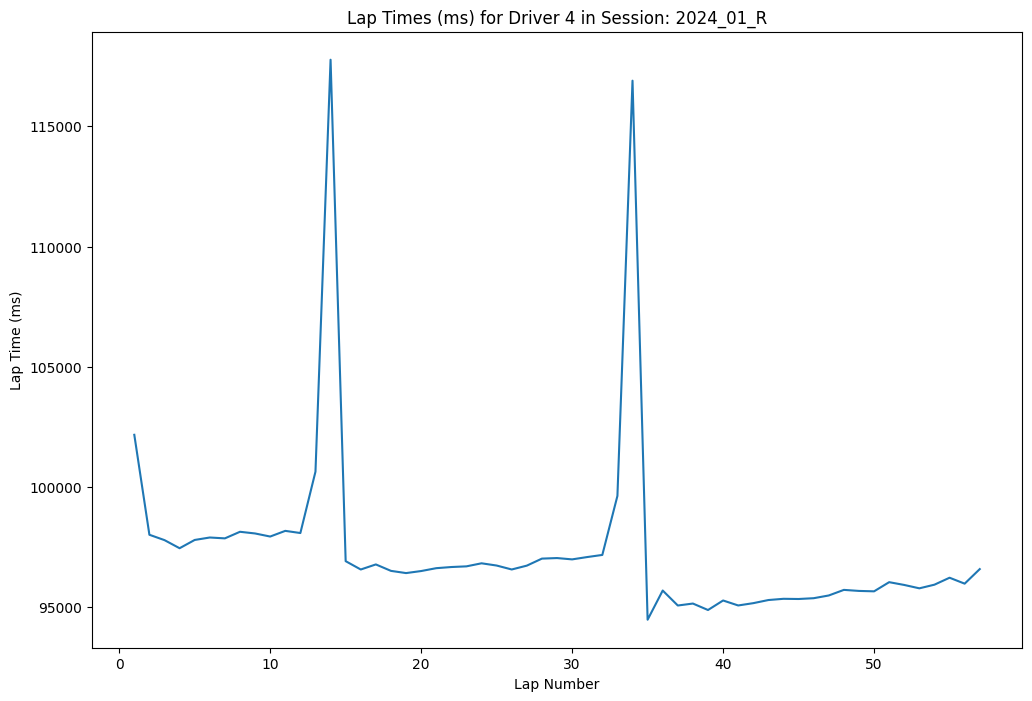

In [14]:
import matplotlib.pyplot as plt

if not laps.empty and {'DriverNumber', 'LapNumber', 'LapTime'}.issubset(laps.columns):
    df = (
        laps.sort_values(['DriverNumber', 'LapNumber']).assign(LapTime_ms = to_ms(laps['LapTime']))
    )

    drv = df['DriverNumber'].dropna().astype(str).value_counts().index[1]
    sub = df[df['DriverNumber'].astype(str) == drv]
    plt.figure(figsize=(12,8))
    plt.plot(sub['LapNumber'], sub['LapTime_ms'])
    plt.title(f'Lap Times (ms) for Driver {drv} in Session: {session_key}')
    plt.xlabel('Lap Number')
    plt.ylabel('Lap Time (ms)')
    plt.show()
else:
    print('Not enough data to plot lap times for a driver.')

# Step 10. Saving a tiny session summary for your notes.

In [15]:
summary = {
    'session_key' : session_key, 
    'laps_rows' : 0 if laps is None else len(laps),
    'weather_rows' : 0 if weather is None else len(weather),
    'results_rows' : 0 if results is None else len(results),
    'drivers_rows' : 0 if drivers is None else len(drivers),
    'drivers_list' : sorted(set(drivers['DriverId'])) if 'DriverId' in drivers.columns and not drivers.empty else None
}

summary_path = PROJECT_DIR / 'notebooks' / '01_exploration_summary.json'
summary_path.write_text(json.dumps(summary, indent=2))
summary, summary_path


({'session_key': '2024_01_R',
  'laps_rows': 1129,
  'weather_rows': 157,
  'results_rows': 20,
  'drivers_rows': 20,
  'drivers_list': None},
 PosixPath('/Users/pratyushagarwal/Desktop/PROJECTS/F1_Projects/race_weekend_data_pipeline/notebooks/01_exploration_summary.json'))